# **EMG for Gesture Detections - Data Exploration**
This notebook loads raw EMG data, cleans and segments it into gestures, visualizes channel behavior, and prepares fixed-length windows for downstream modeling.

## Dataset Description
[DATASET](https://archive.ics.uci.edu/dataset/481/emg+data+for+gestures)

The dataset comprises 36 patients performing hand gestures.
Each subject performed two series, each of which consists of six (seven) basic gestures.
**Each gesture was performed for 3 seconds with a pause of 3 seconds between gestures.**

Each file consist of 10 columns:


*   1 Time (ms)
*   2-9 Channel- eightEMG channels of MYO Thalmic bracelet (V?)
*   10 Class, the labeled group

The labels are named:

*   0 - unmarked data
*   1 - hand at rest
*   2 - hand clenched in a fist
*   3 - wrist flexion
*   4 - wrist extension
*   5 - radial deviations
*   6 - ulnar deviations
*   7 - extended palm


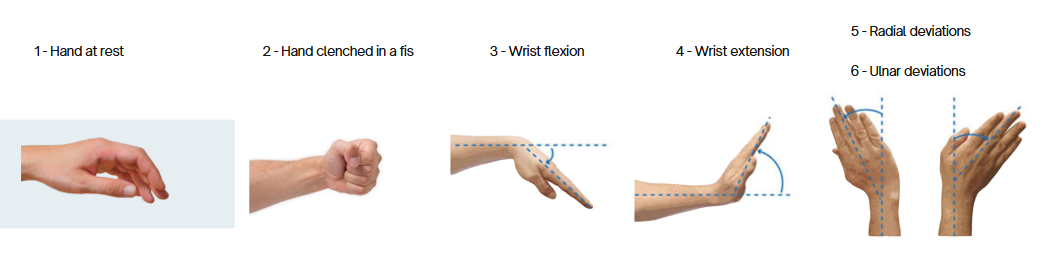

For recording patterns, a MYO Thalmic bracelet is used worn on a user's forearm, and a PC with a Bluetooth receiver. The bracelet is equipped with eight sensors equally spaced around the forearm that simultaneously acquire myographic signals. The signals are sent through a Bluetooth interface to a PC.

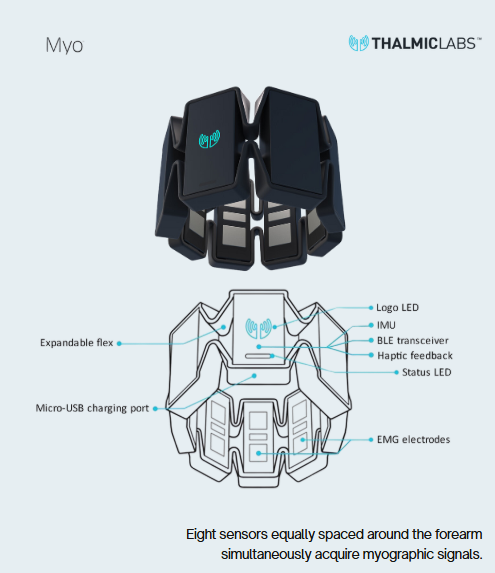



## Importing and environment setup

In [13]:
# Mount Google Drive (if running in Colab)
from google.colab import drive
drive.mount('/content/drive')

# Standard libraries
import os, glob, random, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.patches as mpatches
from scipy.stats import zscore
import seaborn as sns

# TensorFlow / Keras (imported here but used later)
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, \
     Flatten, Dense, Dropout, GaussianNoise, SpatialDropout1D, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

# sklearn metrics (for later)
from sklearn.metrics import confusion_matrix, classification_report

# Set random seed for reproducibility
np.random.seed(1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Load, Preprocess, and Segment EMG Gesture Data



We begin by locating every .txt file in our EMG data folder, loading them into pandas, and concatenating into one DataFrame.

In [5]:
root_dir = "/content/drive/MyDrive/IA_EBM/PROJECT/EMG_data_for_gestures-master"
all_txt  = glob.glob(os.path.join(root_dir, "**", "*.txt"), recursive=True)

dfs = []
for f in tqdm(all_txt, desc="Loading .txt files"):
    # each .txt has EMG channels + class label
    dfs.append(pd.read_csv(f, sep="\t"))

# combine all subjects into one dataset
combined_df = pd.concat(dfs, ignore_index=True)


Loading .txt files: 100%|██████████| 73/73 [00:06<00:00, 11.66it/s]


We remove non-informative classes (0 = unmarked, 7 = extended palm) and assign each continuous run of the same label to its own “segment”.

In [6]:
# remove unwanted labels
df = combined_df[(combined_df['class'] != 0) & (combined_df['class'] != 7)].reset_index(drop=True)

# whenever class changes, that's a new segment
df['segment'] = (df['class'] != df['class'].shift()).cumsum()

# group into per-gesture DataFrames
gesture_datasets = {}
for (g_class, seg), group in tqdm(df.groupby(['class','segment']), desc="Segmenting gestures"):
    key = f"gesture_{int(g_class)}_{seg}"
    gesture_datasets[key] = group.drop(columns=['segment']).reset_index(drop=True)


Segmenting gestures:  98%|█████████▊| 864/883 [00:00<00:00, 1340.77it/s]


To get a quick sense of the signal structure, we plot a slice of raw EMG channels and shade regions by gesture class.

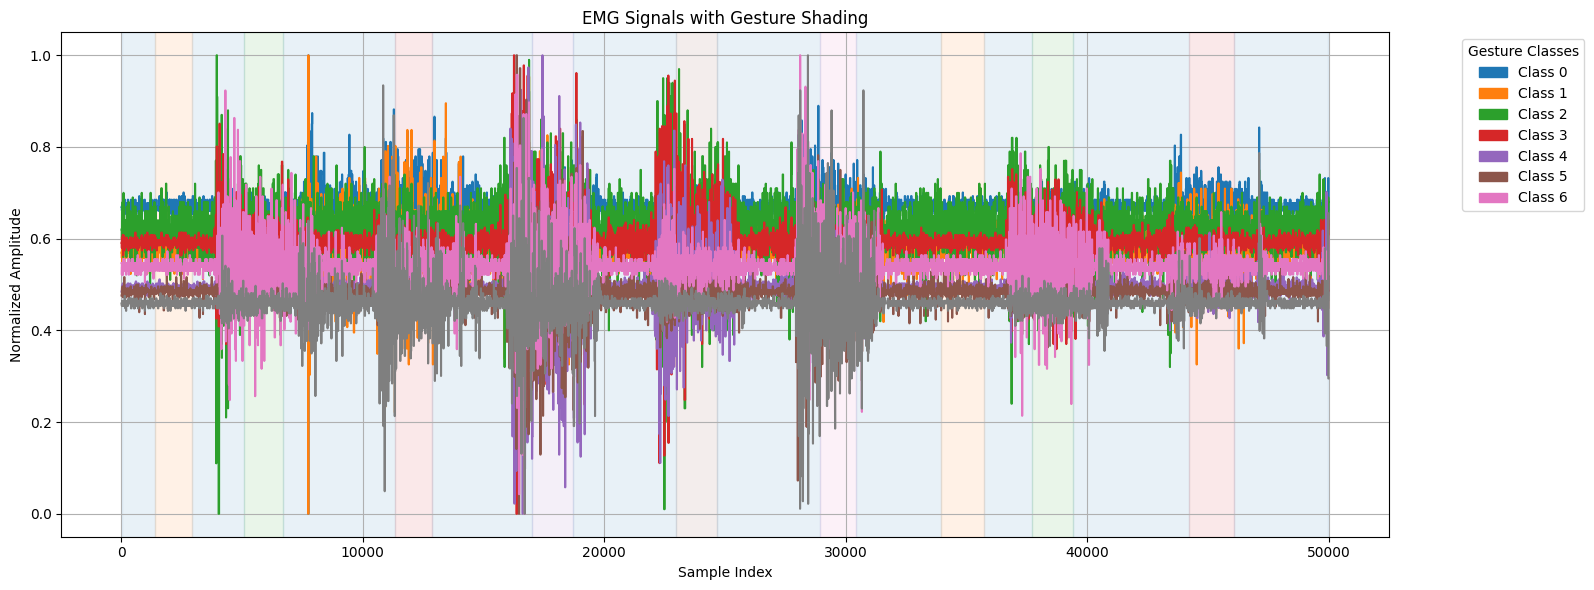

In [7]:
start_idx, end_idx = 0, 50000
plot_df = combined_df.iloc[start_idx:end_idx].dropna(subset=['class']).copy()
emg_channels = [c for c in plot_df.columns if c.startswith("channel")]
class_seq    = plot_df['class'].astype(int).values

# flag where gesture changes
change_mask   = class_seq != np.roll(class_seq, 1)
change_mask[0] = True
change_points = np.where(change_mask)[0]
class_changes = list(change_points) + [len(plot_df)]

plt.figure(figsize=(16,6))
for ch in emg_channels:
    sig      = plot_df[ch].values
    sig_norm = (sig - sig.min())/(sig.max()-sig.min()+1e-8)  # normalize for display
    plt.plot(plot_df.index, sig_norm, label=ch)

# shade by gesture
for i in range(len(class_changes)-1):
    start = plot_df.index[class_changes[i]]
    end   = plot_df.index[class_changes[i+1]-1]
    cls   = class_seq[class_changes[i]]
    plt.axvspan(start, end, color=plt.cm.tab10(cls%10), alpha=0.1)

plt.title('EMG Signals with Gesture Shading')
plt.xlabel('Sample Index')
plt.ylabel('Normalized Amplitude')
plt.grid(True)
handles = [mpatches.Patch(color=plt.cm.tab10(c%10), label=f'Class {c}')
           for c in sorted(np.unique(class_seq))]
plt.legend(handles=handles, title="Gesture Classes", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()


Next, we split whole segments into training, validation, and test sets (60 / 20 / 20), to prevent leakage between gestures.

In [8]:
classes = sorted({int(k.split('_')[1]) for k in gesture_datasets})
train_segs, val_segs, test_segs = [], [], []

for cls in tqdm(classes, desc="Splitting segments"):
    seg_keys = [k for k in gesture_datasets if int(k.split('_')[1]) == cls]
    random.shuffle(seg_keys)
    n_train = int(0.6 * len(seg_keys))
    n_val   = int(0.2 * len(seg_keys))
    # assign segments
    train_segs += seg_keys[:n_train]
    val_segs   += seg_keys[n_train:n_train+n_val]
    test_segs  += seg_keys[n_train+n_val:]

print(f"Segments → train: {len(train_segs)}, val: {len(val_segs)}, test: {len(test_segs)}")


Splitting segments: 100%|██████████| 6/6 [00:00<00:00, 1536.09it/s]

Segments → train: 516, val: 168, test: 180


## Window Extraction

We extract deterministic sliding windows from each segment. Training windows overlap by 50% (step = 125) (typical value used), while validation and test windows do not overlap (step = window size).


The windowing approach standardizes variable-length EMG signals into fixed-size segments, which are ideal for machine learning models. This process offers several benefits:

* Standardization: Fixed-size windows (15 columns wide) ensure that all samples are uniform, a critical requirement for deep learning and other algorithms.

* Feature Extraction: By dividing the continuous signal into smaller, overlapping segments, the model can capture localized patterns and transient features that are characteristic of specific hand gestures.

* Data Augmentation: Overlapping windows generate multiple samples from a single signal, effectively increasing the dataset size and enhancing model robustness.

To extract the windows, a deterministic method has been used

* Deterministic (Sliding) Windows: A fixed-size window slides over the entire signal with a constant step (e.g., every 6 columns). This guarantees systematic, comprehensive coverage of the signal with predictable overlap, preserving temporal continuity.


In [9]:
def extract_deterministic_windows(signal, window_size=250, step=125):
    # signal: (channels, samples)
    # returns list of (channels, window_size) arrays
    return [
        signal[:, i:i+window_size]
        for i in range(0, signal.shape[1]-window_size+1, step)
    ]

window_size = 250
train_w, val_w, test_w = {}, {}, {}

for key in tqdm(gesture_datasets, desc="Extracting windows"):
    gdf  = gesture_datasets[key]
    cols = [c for c in gdf.columns if c.startswith("channel")]
    sig  = gdf[cols].to_numpy().T  # shape: (channels, samples)

    # choose step size
    if   key in train_segs: step, target = 125, train_w
    elif key in val_segs:   step, target = 250, val_w
    else:                   step, target = 250, test_w

    wins = extract_deterministic_windows(sig, window_size, step)
    for i, w in enumerate(wins):
        target[f"{key}_win_{i}"] = w

print("Train windows:", len(train_w),
      "Val windows:",   len(val_w),
      "Test windows:",  len(test_w))


Extracting windows: 100%|██████████| 864/864 [00:00<00:00, 2032.88it/s]

Train windows: 6386 Val windows: 1080 Test windows: 1171


Visualize a few random windows from the training set


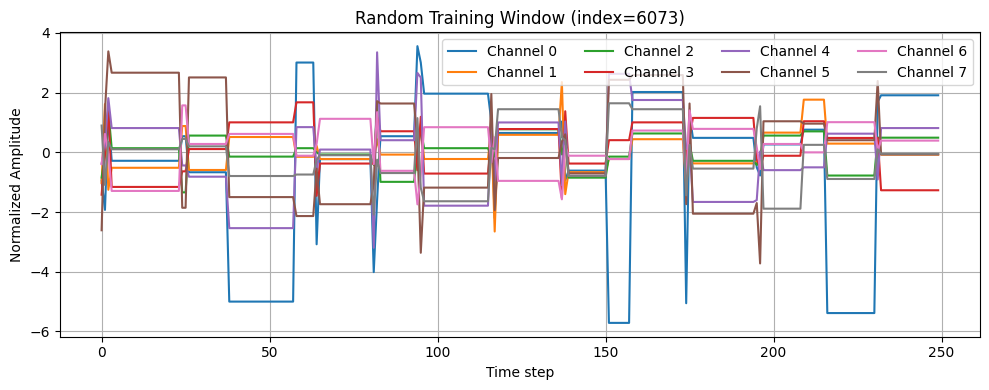

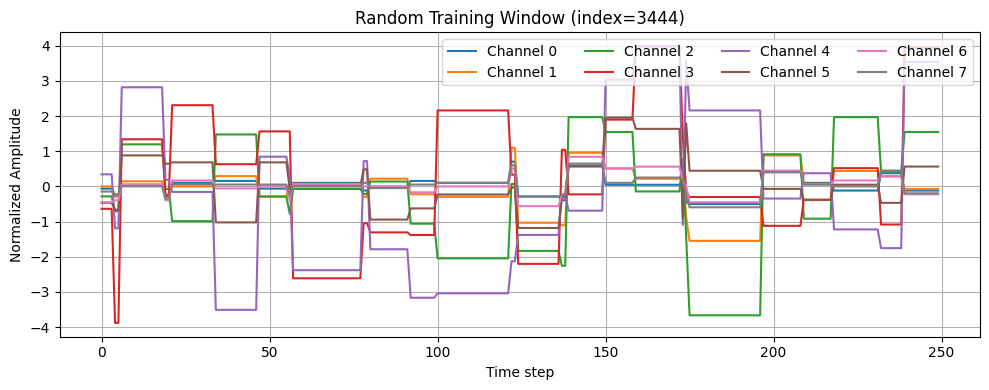

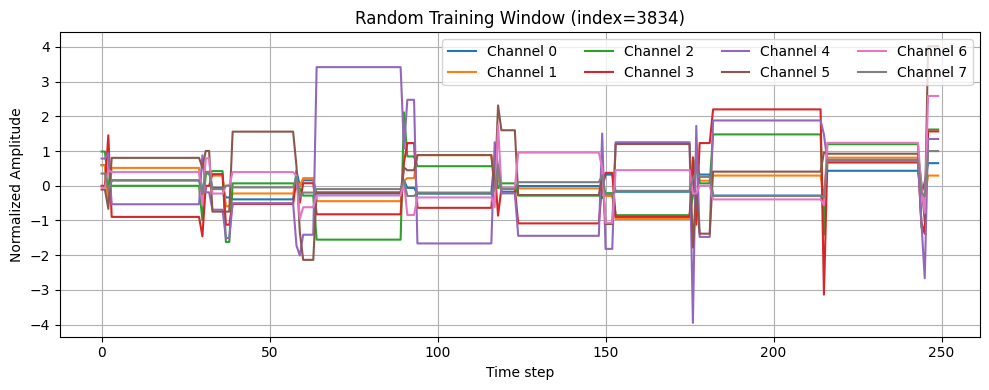

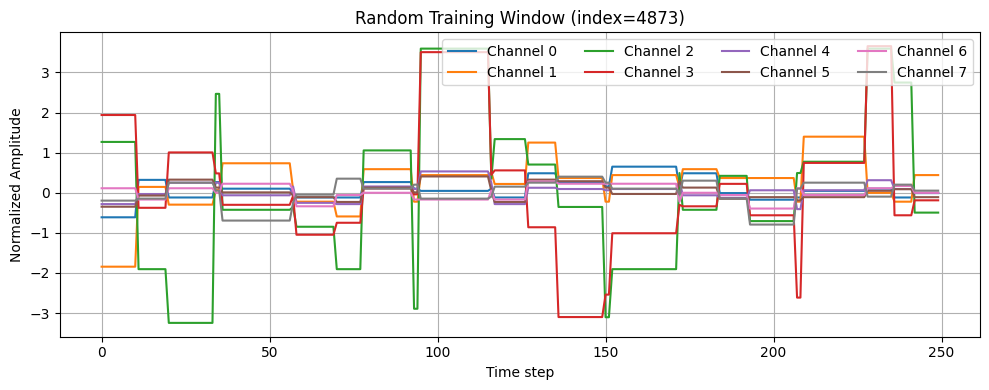

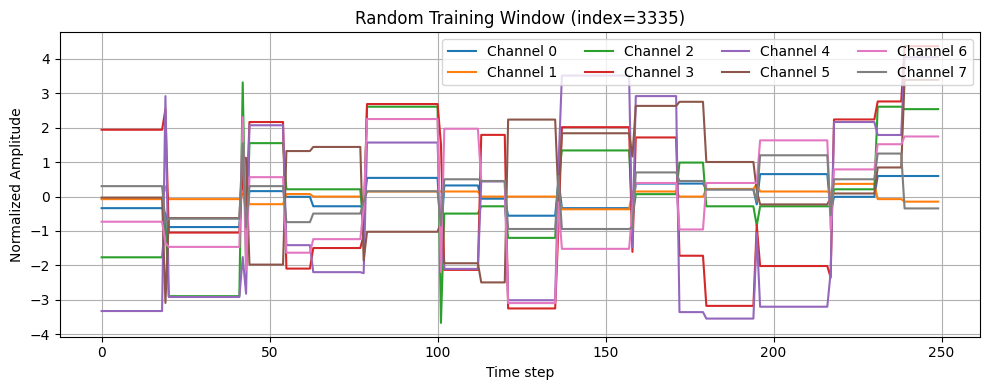

In [16]:
# Pick how many random windows to display
n_samples = 5
# Randomly choose distinct indices from the training set
random_indices = np.random.choice(X_train.shape[0], n_samples, replace=False)

for idx in random_indices:
    plt.figure(figsize=(10, 4))
    # Plot each of the 8 EMG channels for this window
    for ch in range(X_train.shape[2]):
        plt.plot(X_train[idx, :, ch], label=f'Channel {ch}')
    plt.title(f'Random Training Window (index={idx})')
    plt.xlabel('Time step')
    plt.ylabel('Normalized Amplitude')
    plt.legend(loc='upper right', ncol=4)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


## Stack, Label & Normalize

We stack windows into 3D arrays, parse integer labels, then normalize
all splits by training-set mean/std.


In [11]:
def extract_label(key):
    return int(key.split('_')[1])  # from "gesture_<class>_<seg>"

def prepare(wdict):
    X = np.stack([w.T for w in wdict.values()], axis=0)  # (n_samples, window, channels)
    y = np.array([extract_label(k) for k in wdict.keys()])
    return X, y

X_train, y_train = prepare(train_w)
X_val,   y_val   = prepare(val_w)
X_test,  y_test  = prepare(test_w)

# compute train mean/std once
mean = X_train.mean(axis=(0,1), keepdims=True)
std  = X_train.std(axis=(0,1), keepdims=True) + 1e-8

# apply normalization to every split
for arr in (X_train, X_val, X_test):
    arr[:] = (arr - mean) / std

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Shapes: (6386, 250, 8) (1080, 250, 8) (1171, 250, 8)


## Data Quality Checks

Visualize per-channel z-score distributions and ensure class balance.


<ipython-input-14-1521129798>:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(z, labels=[f"Ch{i}" for i in range(z.shape[1])])


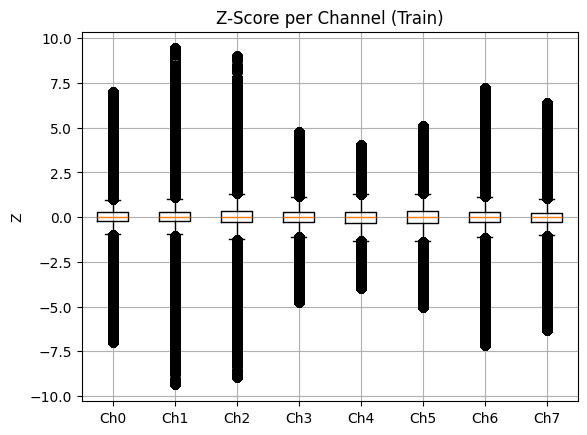

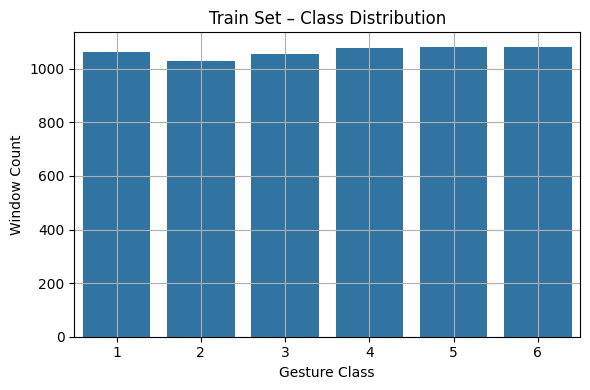

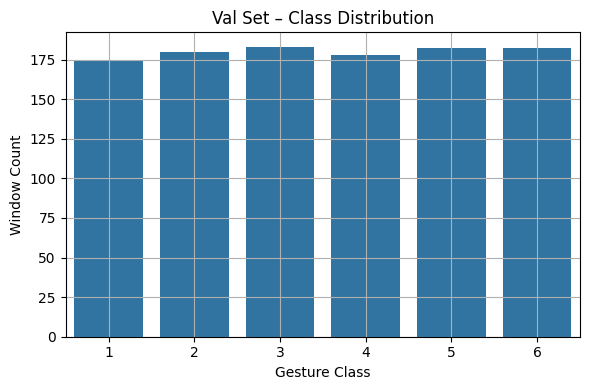

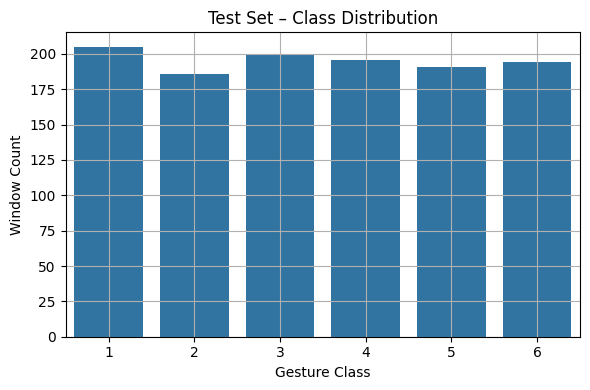

In [14]:
# z-score distribution per channel (train set)
z = zscore(X_train.reshape(-1, X_train.shape[2]), axis=0)
plt.boxplot(z, labels=[f"Ch{i}" for i in range(z.shape[1])])
plt.title("Z-Score per Channel (Train)"); plt.ylabel("Z"); plt.grid(True); plt.show()

# class count plots
for name, labels in zip(["Train","Val","Test"], [y_train, y_val, y_test]):
    plt.figure(figsize=(6,4))
    sns.countplot(x=labels)
    plt.title(f"{name} Set – Class Distribution")
    plt.xlabel("Gesture Class"); plt.ylabel("Window Count")
    plt.grid(True); plt.tight_layout(); plt.show()


## One-Hot Encoding & Custom Callback

Prepare labels for Keras and define a callback that logs train/val accuracy each epoch.


In [15]:
classes_arr = np.unique(y_train)
num_classes = len(classes_arr)
offset      = classes_arr.min()

y_train_enc = to_categorical(y_train - offset, num_classes)
y_val_enc   = to_categorical(y_val   - offset, num_classes)
y_test_enc  = to_categorical(y_test  - offset, num_classes)

class EvalTrainVal(Callback):
    def __init__(self, train_data, val_data):
        super().__init__()
        self.train_data = train_data
        self.val_data   = val_data
        self.eval_metrics = {'train_acc':[], 'val_acc':[]}
    def on_epoch_end(self, epoch, logs=None):
        _, tr = self.model.evaluate(*self.train_data, verbose=0)
        _, va = self.model.evaluate(*self.val_data,   verbose=0)
        self.eval_metrics['train_acc'].append(tr)
        self.eval_metrics['val_acc'].append(va)
        print(f" — train_acc={tr:.4f}, val_acc={va:.4f}")
